# Titanic Exploratory Analysis

### Using the Titanic.csv file, I will answer the following questions:
 - What is the most important factor in determining survival of the Titanic incident?
 - In the movie, the upper-class passengers were given preference on lifeboats. Does this show in the data?
 - “Women and children first”. Was this the case?
 - Add one other observation that you have noted in the dataset.

In [1]:
# Import necessary packages for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgo
import miceforest as mice
titanic = pd.read_csv("Titanic.csv")

To start, I will load in the dataset and print the first 5 rows to see what columns there are to work with to answer the questions above

In [2]:
titanic.head()
titantic_dropped = pd.DataFrame(titanic, columns=["Name", "Sex", "Ticket", "Embarked"])
titantic_dropped.head()

,Name,Sex,Ticket,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S


Looking at the head of the dataset above, I can already see that there are NaN values present, I will now look into these further

In [3]:
missing_values = titanic.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


 - The above table shows that there are indeed missing values. The cabin number has the most missing values and I feel that this column of data will not contribute towards the overall answers for this notebook. Therefore, I will drop the "cabin" column. 
 - As "embarked" only has 2 missing values, I will be able to use simple imputation with the mode to determine the missing values. The outcome will be one of 3 ports (S, C, Q).
 - Age has 177 missing values and this column will be pivotful in filling in to answer the questions, as there are too many to simply drop and as they will be Missing At Random (MAR), I will use advanced imputation to estimate the missing values.

In [4]:
# Drop the "cabin" column and fill the "embarked" column with the mode value
titanic = titanic.drop(["Cabin"], axis=1)
titanic["Embarked"].fillna(titanic["Embarked"].mode()[0], inplace=True)
print(titanic.isnull().sum())



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64


C:\Users\gramp\AppData\Local\Temp\ipykernel_19872\442735779.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic["Embarked"].fillna(titanic["Embarked"].mode()[0], inplace=True)


Based on that there are 177 missing ages, I will be using advanced imputation. To do this I will be using the Miceforest package which uses machine learning and decision trees to take in all the numerical values to determine the missing values. To start, I will change the sex to numbers, where male will be 0 and female will be 1 and place these numerical columns into their own dataframe. Then I will use MICE to correct the ages, I will run this for 10 iterations for the best result, and I will use the seed number as 1912 for reproducibility.

*I used 1912 as the seed number as this is the year the Titanic sank*

In [5]:
titanic_numbers = titanic
titanic_numbers.replace(["male", "female"], [0, 1], inplace=True)
titanic_numbers.drop(["Embarked", "Ticket", "Name"], axis=1, inplace=True)
titanic_numbers.head()


C:\Users\gramp\AppData\Local\Temp\ipykernel_19872\516343801.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titanic_numbers.replace(["male", "female"], [0, 1], inplace=True)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,0,22.0,1,0,7.2500
1,2,1,1,1,38.0,1,0,71.2833
2,3,1,3,1,26.0,0,0,7.9250
3,4,1,1,1,35.0,1,0,53.1000
4,5,0,3,0,35.0,0,0,8.0500


In [6]:
kds = mice.ImputationKernel(titanic_numbers, save_all_iterations=True, random_state=1912)
kds.mice(10)
titanic_complete = kds.complete_data()
print(titanic_complete.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64


Following the machine learning aspect of this notebook, I wanted to check what the distribution of ages was pre and post MICE. Below are the histograms comparing the distribution of ages after the missing values have been calculated

Text(0.5, 1.0, 'Complete Data for Distribution of Ages')

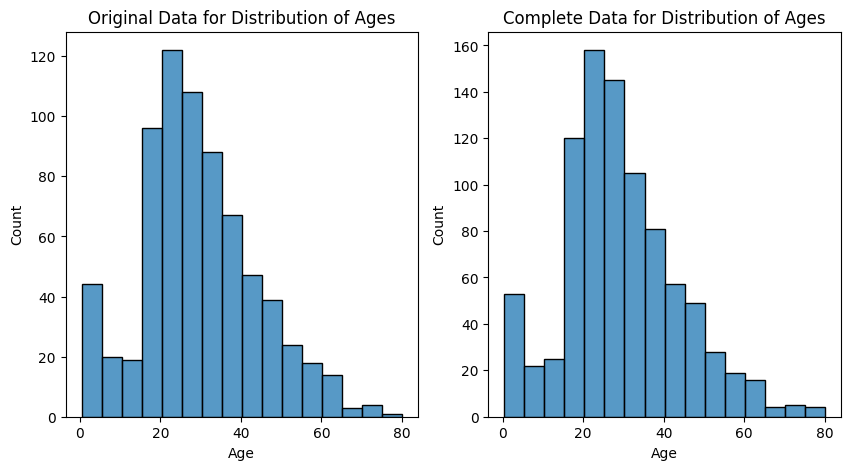

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=titanic, x="Age", binwidth=5)
plt.title("Original Data for Distribution of Ages")
plt.subplot(1, 2, 2)
sns.histplot(data=titanic_complete, x="Age", binwidth=5)
plt.title("Complete Data for Distribution of Ages")


Following the addition of the missing values, I can now stitch the data back together for a complete dataset

In [8]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,0,22.0,1,0,7.2500
1,2,1,1,1,38.0,1,0,71.2833
2,3,1,3,1,26.0,0,0,7.9250
3,4,1,1,1,35.0,1,0,53.1000
4,5,0,3,0,35.0,0,0,8.0500


In [9]:
titanic_complete.rename(columns={"Age": "Age_Complete"}, inplace=True)
titanic_complete.drop(["PassengerId", "Survived", "Pclass", "Sex", "SibSp", "Parch", "Fare"], axis=1)
titanic = titanic.merge(titanic_complete, left_on=None)
titanic.drop(["Age", "Sex"], axis=1, inplace=True)
titanic = pd.concat([titanic, titantic_dropped], axis=1)
titanic.head()


,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age_Complete,Name,Sex,Ticket,Embarked
0,1,0,3,1,0,7.2500,22.0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,2,1,1,1,0,71.2833,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,3,1,3,0,0,7.9250,26.0,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,4,1,1,1,0,53.1000,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,5,0,3,0,0,8.0500,35.0,"Allen, Mr. William Henry",male,373450,S


## The most important factor in determining survivability

<function matplotlib.pyplot.show(close=None, block=None)>

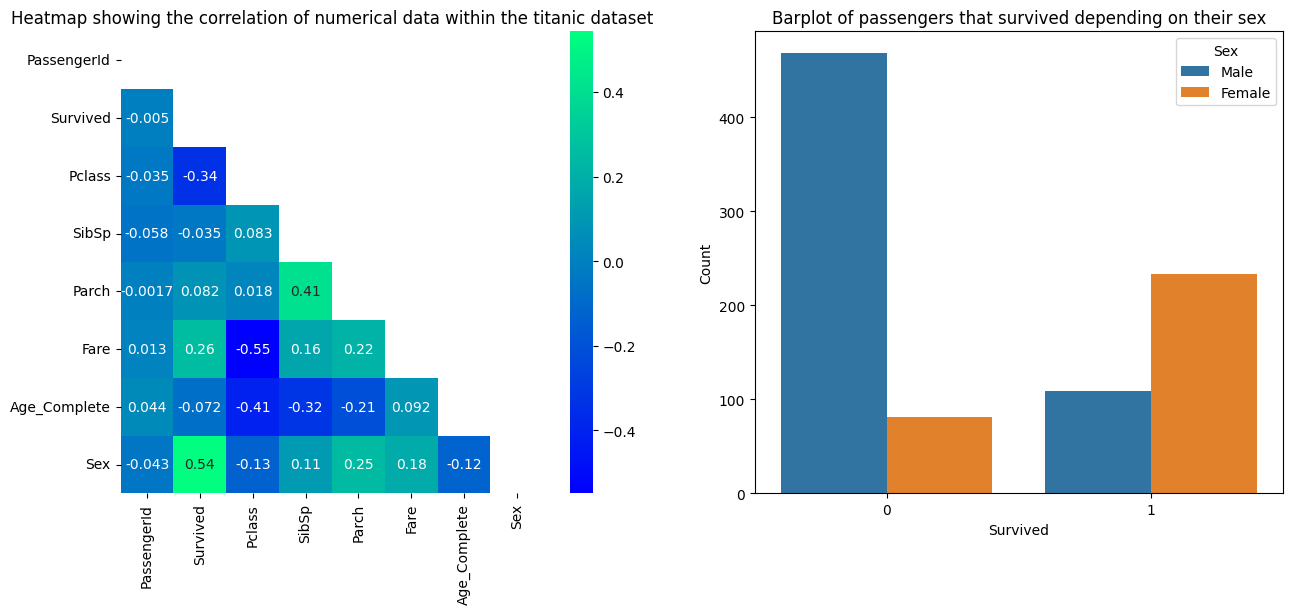

In [40]:
titanic.replace(["male", "female"], [0, 1], inplace=True)
titanic_num = titanic.select_dtypes(include=[np.int64, np.float64])
corr = titanic_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(corr, mask=mask, annot=True, cmap="winter")
plt.title("Heatmap showing the correlation of numerical data within the titanic dataset")
plt.subplot(1, 2, 2)
sns.countplot(data=titanic, x="Survived", hue="Sex",)
plt.title("Barplot of passengers that survived depending on their sex")
plt.legend(["Male", "Female"], title="Sex")
plt.ylabel("Count")
plt.show

 - The above graphs show that the most correlated value for determining survivability is the sex of the passenger at 0.54, I have then confirmed this with a bar plot counting the survived and split between sex. 
 - From this, is shows that females were more likely to survive the Titanic sinking than males.

## First Class preferential treatment for lifeboats

Text(0.5, 1.0, 'Barplot showing the numbers of passengers that survived based upon the class they were travelling in')

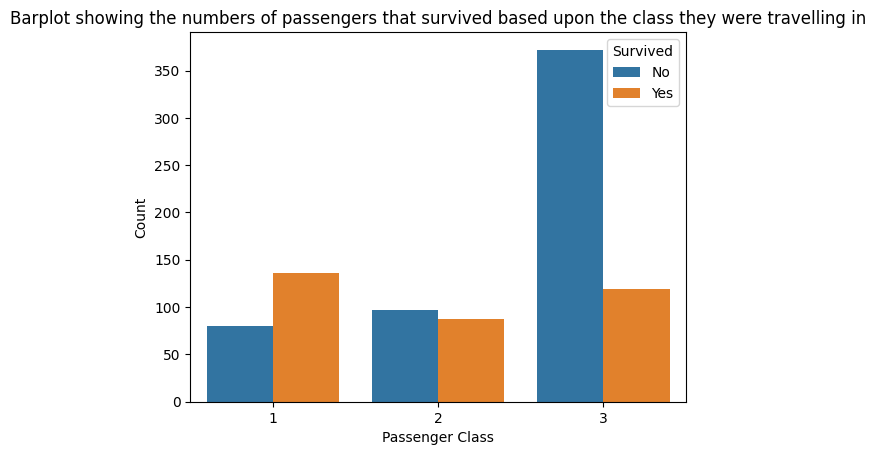

In [42]:
plt.figure()
sns.countplot(data=titanic, x="Pclass", hue="Survived")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(["No", "Yes"], title="Survived")
plt.title("Barplot showing the numbers of passengers that survived based upon the class they were travelling in")

 - From the above plot, it shows that more first class passengers survived than those that didn't from the same class. 
 - It also shows that third class had over 3 times the amount of people that died than survived from the same class. 
 - The data does not go into detail about who was in specific lifeboats, but it does support the theory that first class passengers were given preferential access to lifeboats.

## Women & Children first

Due to the ambiguity of what would class as a child, I will filter the data into 0-12, 13-17, 18+ male and 18+ female

Text(0.5, 1.0, 'Passengers aged 18+ and male')

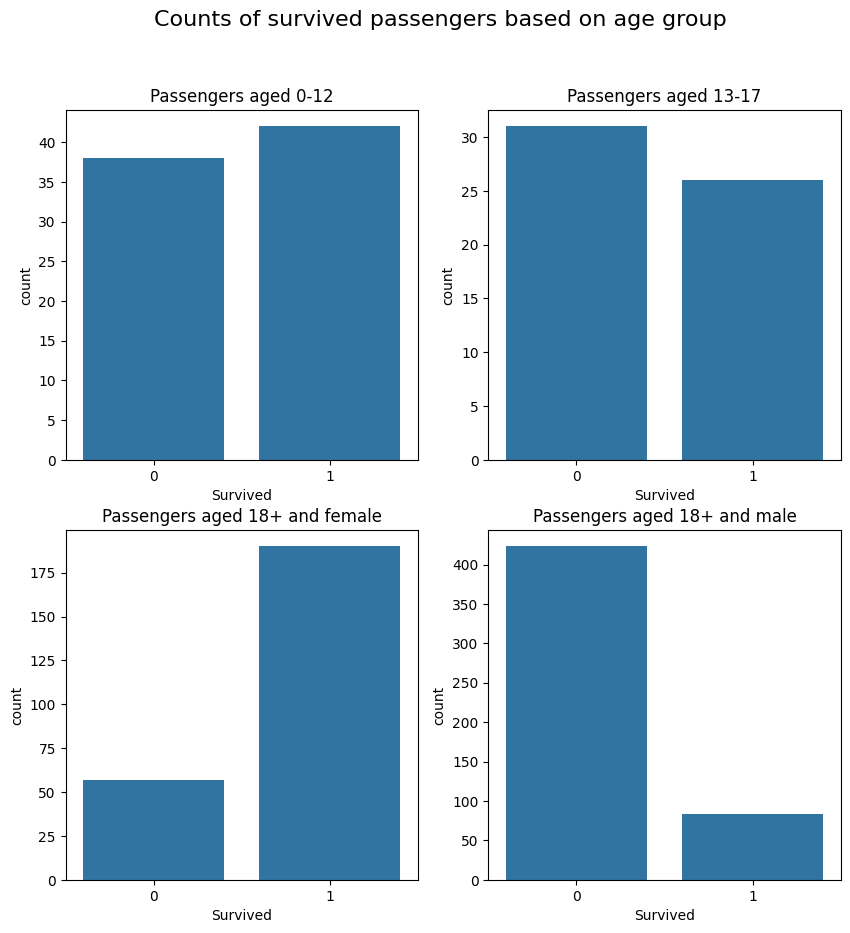

In [76]:
child = titanic[titanic["Age_Complete"] <= 12]
teenager = titanic[(titanic["Age_Complete"] >= 13) & (titanic["Age_Complete"] <= 17)]
adult_male = titanic[(titanic["Age_Complete"] >= 18) & (titanic["Sex"] == 0)]
adult_female = titanic[(titanic["Age_Complete"] >= 18) & (titanic["Sex"] == 1)]

plt.figure(figsize=(10, 10))
plt.suptitle("Counts of survived passengers based on age group", fontsize=16)
plt.subplot(2, 2, 1)
sns.countplot(data=child, x="Survived")
plt.title("Passengers aged 0-12")
plt.subplot(2, 2, 2)
sns.countplot(data=teenager, x="Survived")
plt.title("Passengers aged 13-17")
plt.subplot(2, 2, 3)
sns.countplot(data=adult_female, x="Survived")
plt.title("Passengers aged 18+ and female")
plt.subplot(2, 2, 4)
sns.countplot(data=adult_male, x="Survived")
plt.title("Passengers aged 18+ and male")


 - The group of plots show that roughly equal numbers of children survived across both age groups. 
 - The data also shows that about 3 times the amount of adult females survived than didn't. 
 - Finally, about 8 times as many adult males died than survived

## One other observation

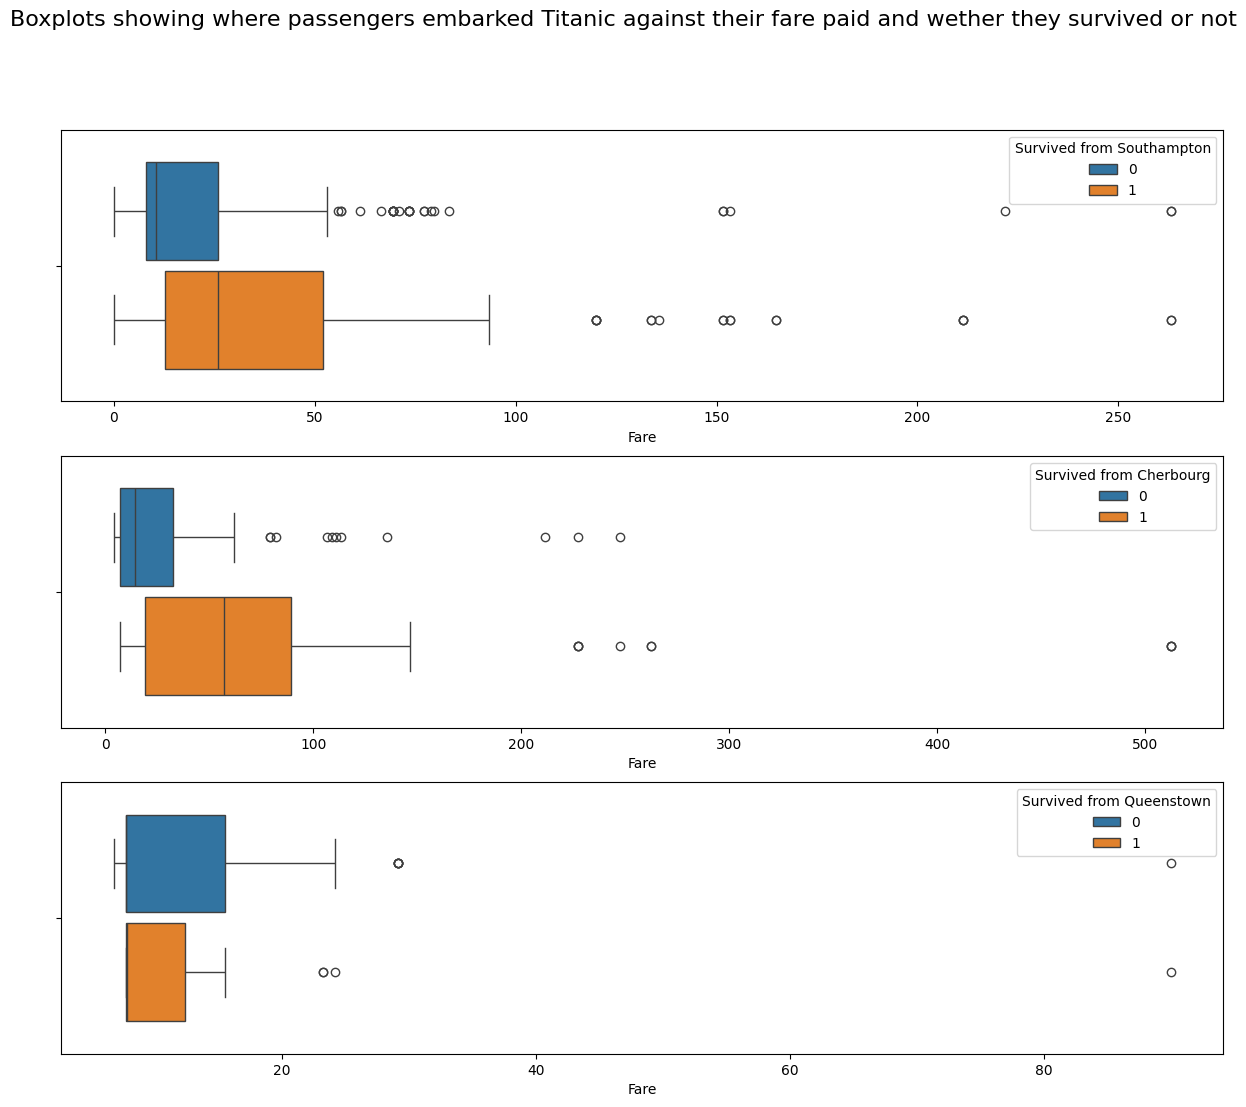

In [92]:
southampton = titanic[titanic["Embarked"] == "S"]
cherbourg = titanic[titanic["Embarked"] == "C"]
queenstown = titanic[titanic["Embarked"] == "Q"]

plt.figure(figsize=(15, 12))
plt.suptitle("Boxplots showing where passengers embarked Titanic against their fare paid and wether they survived or not", fontsize=16)
plt.subplot(3, 1, 1)
sns.boxplot(data=southampton, x="Fare", hue="Survived", gap=0.1)
plt.legend(title="Survived from Southampton")
plt.subplot(3, 1, 2)
sns.boxplot(data=cherbourg, x="Fare", hue="Survived", gap=0.1)
plt.legend(title="Survived from Cherbourg")
plt.subplot(3, 1, 3)
sns.boxplot(data=queenstown, x="Fare", hue="Survived", gap=0.1)
plt.legend(title="Survived from Queenstown")


 - These boxplots show that passengers from Cherbourg paid some of the highest fares on board Titanic.
 - The data also shows that generally, the higher the fare paid, the more chance you would have to survive.